In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
os.chdir("/usr/FlexFlow/inference/output")
print(os.getcwd())

/usr/FlexFlow/inference/output


In [2]:
small_model_names = [
    "Zhuominc/Llama-3-330M",
    "meta-llama/Llama-3.2-1B-Instruct",
    # "meta-llama/Llama-3.2-3B-Instruct",
    "meta-llama/Llama-3.1-8B-Instruct",
]
batch_sizes=[4,8]
arrival_rates=["offline", "1", "2", "4", "8"]

In [3]:
def get_speculation_len(filepath):
    df = pd.read_csv(filepath)
    # remove entries where is_warmup_request is 1 or request_step_idx is < 0
    df = df[(df["is_warmup_request"] == 0) & (df["request_step_idx"] >= 0)]
    return df["num_speculated_tokens"].mean()

def get_accepted_len(filepath):
    df = pd.read_csv(filepath)
    # remove entries where is_warmup_request is 1 or request_step_idx is < 0
    df = df[(df["is_warmup_request"] == 0) & (df["request_step_idx"] >= 0)]
    return df["num_accepted_tokens"].mean()

def get_acceptance_rates(filepath):
    df = pd.read_csv(filepath)
    # remove entries where is_warmup_request is 1 or request_step_idx is < 0
    df = df[(df["is_warmup_request"] == 0) & (df["request_step_idx"] >= 0)]
    # group = df.groupby("request_guid", as_index=False)
    num_speculated_tokens = df["num_speculated_tokens"].sum()
    num_accepted_tokens = df["num_accepted_tokens"].sum()
    return num_accepted_tokens/num_speculated_tokens

def get_tpot(filepath):
    df = pd.read_csv(filepath)
    # remove entries where is_warmup_request is 1 or request_step_idx is < 0
    df = df[(df["is_warmup_request"] == 0) & (df["request_step_idx"] >= 0)]
    group = df.groupby("request_guid", as_index=False)
    min_time = group["timestamp"].min()["timestamp"]
    max_time = group["timestamp"].max()["timestamp"]
    num_tokens = group["num_generated_tokens"].sum()["num_generated_tokens"]
    tpots = (max_time - min_time) / num_tokens / 1000
    return tpots.mean()

def get_throughput(filepath):
    df = pd.read_csv(filepath)
    # remove entries where is_warmup_request is 1 or request_step_idx is < 0
    df = df[(df["is_warmup_request"] == 0) & (df["request_step_idx"] >= 0)]
    num_tokens = df["num_generated_tokens"].sum()
    total_time = df["timestamp"].max() - df["timestamp"].min() # in microseconds
    total_time = total_time / 1000000 # convert to seconds
    throughput = num_tokens / total_time # (tokens/sec)
    return throughput

def get_ttft(filepath):
    df = pd.read_csv(filepath)
    # remove entries where is_warmup_request is 1
    df = df[(df["is_warmup_request"] == 0)]
    group = df.groupby("request_guid", as_index=False)
    ttft = group.apply(lambda x: x[x["request_step_idx"] == 0]["timestamp"].values[0] - x[x["request_step_idx"] == -1]["timestamp"].values[0])
    # convert to milliseconds from microseconds
    return ttft.mean()[1] / 1000

def get_queueing_time(filepath):
    df = pd.read_csv(filepath)
    # remove entries where is_warmup_request is 1
    df = df[(df["is_warmup_request"] == 0)]
    group = df.groupby("request_guid", as_index=False)
    # in each group, find the difference between the timestampt at request_step_idx=-1 and the timestamp at request_step_idx=-2.
    queueing_time = group.apply(lambda x: x[x["request_step_idx"] == -1]["timestamp"].values[0] - x[x["request_step_idx"] == -2]["timestamp"].values[0])
    # convert to seconds from microseconds
    return queueing_time.mean()[1] / 1000000



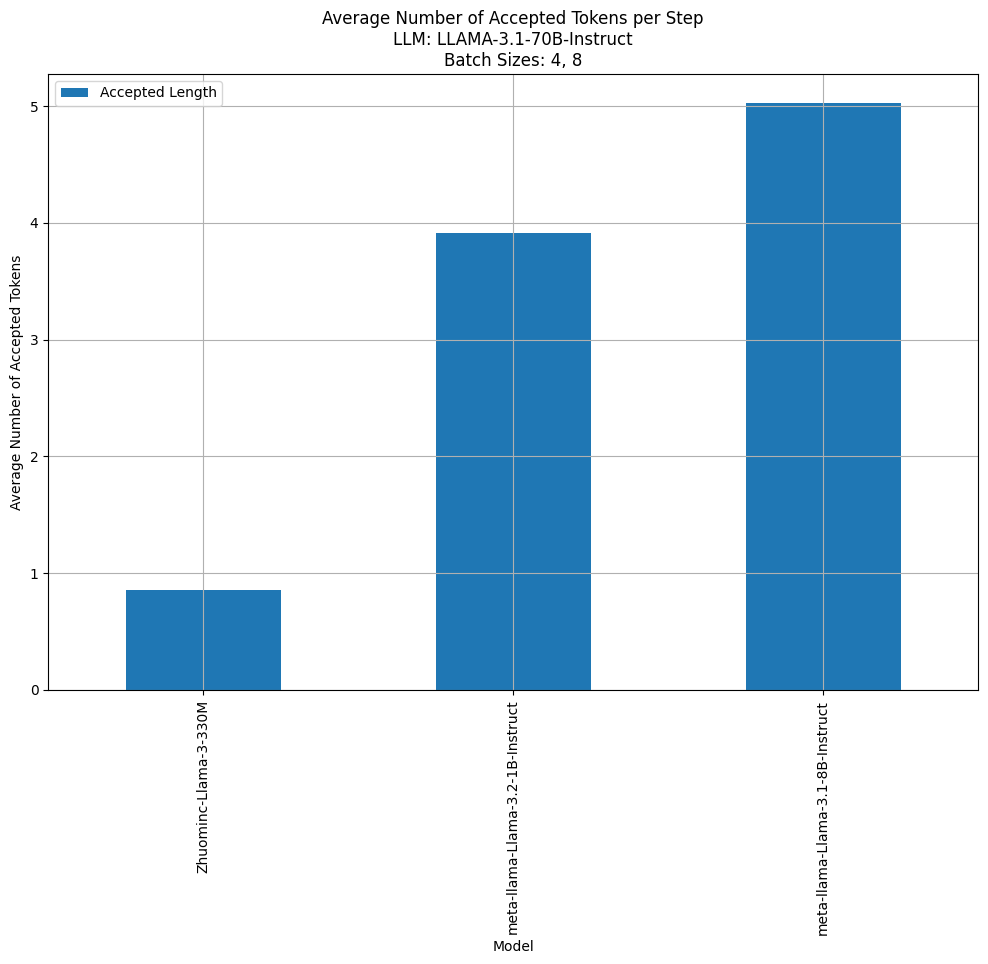

In [4]:
accepted_lengths = []

for ssm in small_model_names:
    for batch_size in batch_sizes:
        for arrival_rate in arrival_rates:
            model_name = ssm.replace("/", "-")
            filepath = f"/usr/FlexFlow/inference/output/specinfer_llm_meta-llama-Llama-3.1-70B-Instruct_ssm_{model_name}_bz_{batch_size}_rate_{arrival_rate}_dataset_sharegpt.csv"
            if os.path.exists(filepath):
                accepted_lengths.append({
                    'Model': model_name,
                    'Batch Size': batch_size,
                    'Arrival Rate': arrival_rate,
                    'Accepted Length': get_accepted_len(filepath)
                })

accepted_df = pd.DataFrame(accepted_lengths)

# # Create a bar plot
# fig, ax = plt.subplots(figsize=(12, 8))
# accepted_df.pivot_table(index=['Model', 'Batch Size'], columns='Arrival Rate', values='Accepted Length').plot(kind='bar', ax=ax)
# plt.title('Accepted Length by Model, Batch Size, and Arrival Rate')
# plt.ylabel('Accepted Length')
# plt.xlabel('Model and Batch Size')
# plt.legend(title='Arrival Rate')
# plt.show()
# Group by model and calculate the mean of accepted lengths
average_accepted_df = accepted_df.groupby('Model')['Accepted Length'].mean().reset_index()

# Sort the dataframe by 'Accepted Length' in ascending order
average_accepted_df = average_accepted_df.sort_values(by='Accepted Length')

# Create a bar plot
fig, ax = plt.subplots(figsize=(12, 8))
average_accepted_df.plot(x='Model', y='Accepted Length', kind='bar', ax=ax)
plt.title('Average Number of Accepted Tokens per Step\nLLM: LLAMA-3.1-70B-Instruct\nBatch Sizes: 4, 8')
plt.ylabel('Average Number of Accepted Tokens')
plt.xlabel('Model')
plt.grid(True)  # Turn the grid on

# Save the plot as a PDF
plt.savefig('/usr/FlexFlow/benchmarking/average_accepted_tokens.pdf', bbox_inches='tight')

plt.show()


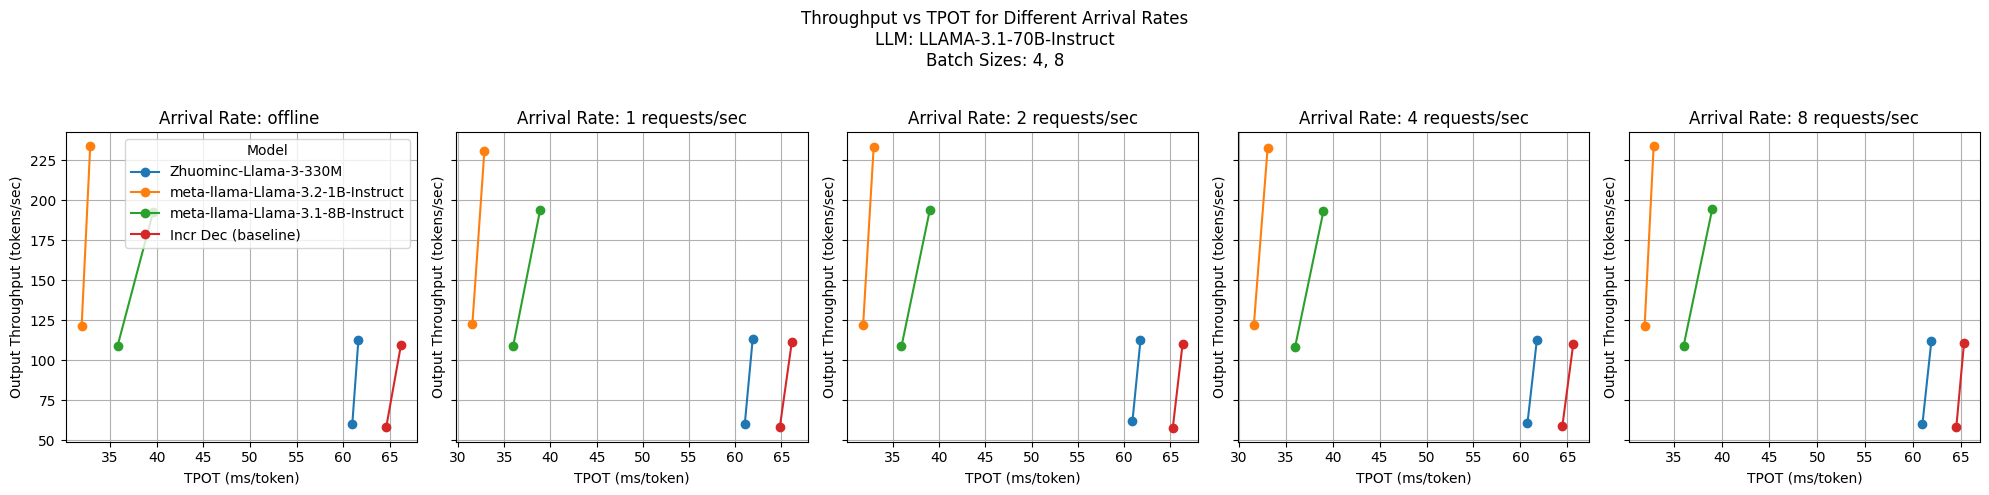

In [5]:
# Create a list to store the throughput and tpot data
throughput_tpot_data = []

# Iterate over the models, batch sizes, and arrival rates to calculate throughput and tpot
for ssm in small_model_names:
    for batch_size in batch_sizes:
        for arrival_rate in arrival_rates:
            model_name = ssm.replace("/", "-")
            filepath = f"/usr/FlexFlow/inference/output/specinfer_llm_meta-llama-Llama-3.1-70B-Instruct_ssm_{model_name}_bz_{batch_size}_rate_{arrival_rate}_dataset_sharegpt.csv"
            if os.path.exists(filepath):
                throughput = get_throughput(filepath)
                tpot = get_tpot(filepath)
                throughput_tpot_data.append({
                    'Model': model_name,
                    'Batch Size': batch_size,
                    'Arrival Rate': arrival_rate,
                    'Throughput': throughput,
                    'TPOT': tpot
                })

# add incremental decoding entry
for batch_size in batch_sizes:
    for arrival_rate in arrival_rates:
        model_name = ssm.replace("/", "-")
        filepath = f"/usr/FlexFlow/inference/output/incr_dec_llm_meta-llama-Llama-3.1-70B-Instruct_bz_{batch_size}_rate_{arrival_rate}_dataset_sharegpt.csv"
        if os.path.exists(filepath):
            throughput = get_throughput(filepath)
            tpot = get_tpot(filepath)
            throughput_tpot_data.append({
                'Model': "Incr Dec (baseline)",
                'Batch Size': batch_size,
                'Arrival Rate': arrival_rate,
                'Throughput': throughput,
                'TPOT': tpot
            })

# Convert the list to a DataFrame
throughput_tpot_df = pd.DataFrame(throughput_tpot_data)

# Plot the data
fig, axes = plt.subplots(nrows=1, ncols=len(arrival_rates), figsize=(20, 5), sharey=True)

for i, arrival_rate in enumerate(arrival_rates):
    ax = axes[i]
    for model_name in throughput_tpot_df['Model'].unique():
        model_data = throughput_tpot_df[(throughput_tpot_df['Model'] == model_name) & (throughput_tpot_df['Arrival Rate'] == arrival_rate)]
        ax.plot(model_data['TPOT'], model_data['Throughput'], marker='o', label=model_name)
        ax.set_title(f'Arrival Rate: {arrival_rate} {"requests/sec" if arrival_rate != "offline" else ""}')
        ax.set_xlabel('TPOT (ms/token)')
        ax.set_ylabel('Output Throughput (tokens/sec)')
        ax.grid(True)
    if i == 0:
        ax.legend(title='Model')

plt.suptitle('Throughput vs TPOT for Different Arrival Rates\nLLM: LLAMA-3.1-70B-Instruct\nBatch Sizes: 4, 8')
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Save the plot as a PDF
plt.savefig('/usr/FlexFlow/benchmarking/throughput_vs_tpot.pdf')

plt.show()

/tmp/ipykernel_3415116/2453520981.py:48: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ttft = group.apply(lambda x: x[x["request_step_idx"] == 0]["timestamp"].values[0] - x[x["request_step_idx"] == -1]["timestamp"].values[0])
/tmp/ipykernel_3415116/2453520981.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return ttft.mean()[1] / 1000
/tmp/ipykernel_3415116/2453520981.py:48: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of p

                   Model  Batch Size Arrival Rate        TTFT
0  Zhuominc-Llama-3-330M           4      offline  236.037453
1  Zhuominc-Llama-3-330M           4            1  239.494513
2  Zhuominc-Llama-3-330M           4            2  236.035863
3  Zhuominc-Llama-3-330M           4            4  237.153932
4  Zhuominc-Llama-3-330M           4            8  237.309231


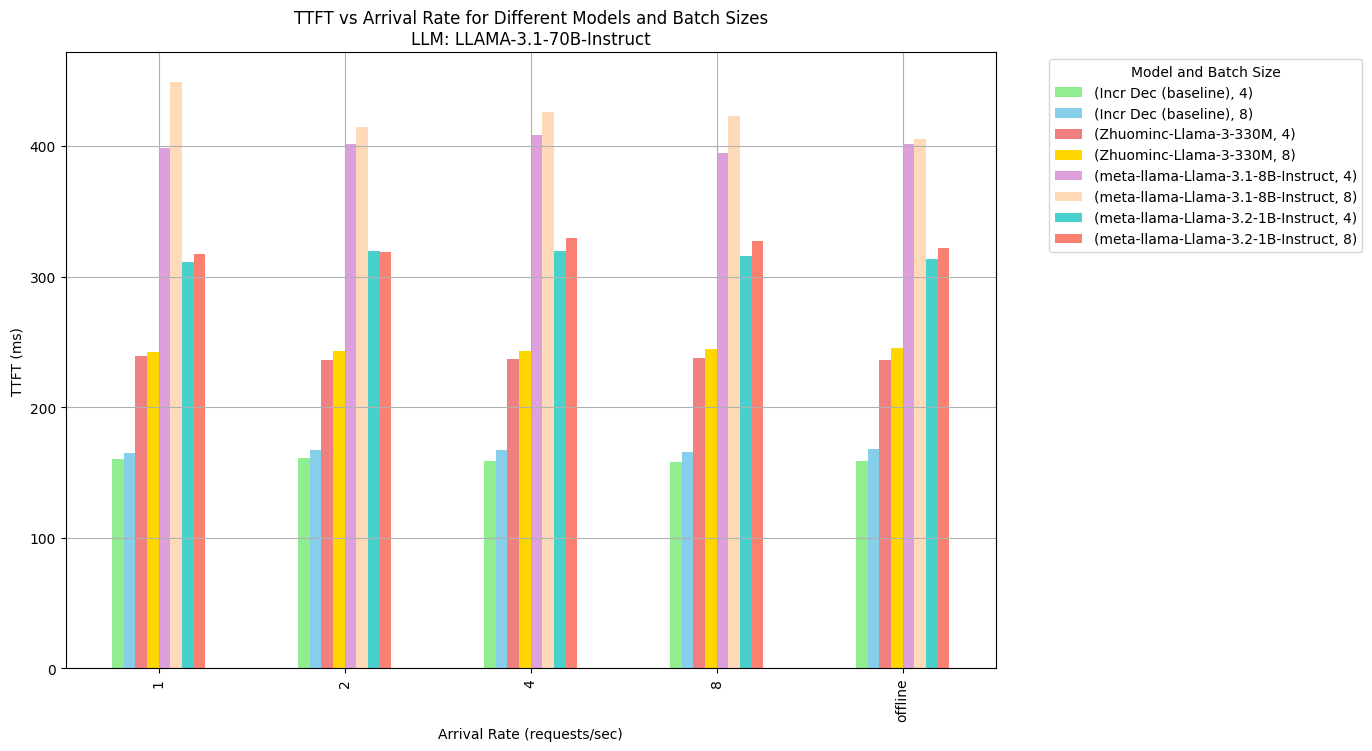

In [7]:
# Create a list to store the TTFT data
ttft_data = []

# Iterate over the models, batch sizes, and arrival rates to calculate TTFT
for ssm in small_model_names:
    for batch_size in batch_sizes:
        for arrival_rate in arrival_rates:
            model_name = ssm.replace("/", "-")
            filepath = f"/usr/FlexFlow/inference/output/specinfer_llm_meta-llama-Llama-3.1-70B-Instruct_ssm_{model_name}_bz_{batch_size}_rate_{arrival_rate}_dataset_sharegpt.csv"
            if os.path.exists(filepath):
                ttft = get_ttft(filepath)
                ttft_data.append({
                    'Model': model_name,
                    'Batch Size': batch_size,
                    'Arrival Rate': arrival_rate,
                    'TTFT': ttft
                })
# add incremental decoding entry
for batch_size in batch_sizes:
    for arrival_rate in arrival_rates:
        model_name = ssm.replace("/", "-")
        filepath = f"/usr/FlexFlow/inference/output/incr_dec_llm_meta-llama-Llama-3.1-70B-Instruct_bz_{batch_size}_rate_{arrival_rate}_dataset_sharegpt.csv"
        if os.path.exists(filepath):
            ttft = get_ttft(filepath)
            ttft_data.append({
                'Model': "Incr Dec (baseline)",
                'Batch Size': batch_size,
                'Arrival Rate': arrival_rate,
                'TTFT': ttft
            })

# Convert the list to a DataFrame
ttft_df = pd.DataFrame(ttft_data)
print(ttft_df.head())

# Pivot the dataframe to have models and batch sizes as columns
pivot_df = ttft_df.pivot_table(index='Arrival Rate', columns=['Model', 'Batch Size'], values='TTFT')

# Plot the data
fig, ax = plt.subplots(figsize=(12, 8))

colors = ['lightgreen', 'skyblue', 'lightcoral', 'gold', 'plum', 'peachpuff', 'mediumturquoise', 'salmon']
pivot_df.plot(kind='bar', ax=ax, color=colors)

ax.set_title('TTFT vs Arrival Rate for Different Models and Batch Sizes\nLLM: LLAMA-3.1-70B-Instruct')
ax.set_xlabel('Arrival Rate (requests/sec)')
ax.set_ylabel('TTFT (ms)')
ax.grid(True)
ax.legend(title='Model and Batch Size', bbox_to_anchor=(1.05, 1), loc='upper left')

# Save the plot as a PDF
plt.savefig('/usr/FlexFlow/benchmarking/ttft_vs_arrival_rate.pdf', bbox_inches='tight')

plt.show()


/tmp/ipykernel_3339078/2453520981.py:58: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  queueing_time = group.apply(lambda x: x[x["request_step_idx"] == -1]["timestamp"].values[0] - x[x["request_step_idx"] == -2]["timestamp"].values[0])
/tmp/ipykernel_3339078/2453520981.py:60: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return queueing_time.mean()[1] / 1000000
/tmp/ipykernel_3339078/2453520981.py:58: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in

                   Model  Batch Size Arrival Rate  Queueing Time
0  Zhuominc-Llama-3-330M           4      offline     376.053818
1  Zhuominc-Llama-3-330M           4            1     319.585296
2  Zhuominc-Llama-3-330M           4            2     346.747481
3  Zhuominc-Llama-3-330M           4            4     360.138720
4  Zhuominc-Llama-3-330M           4            8     368.694877


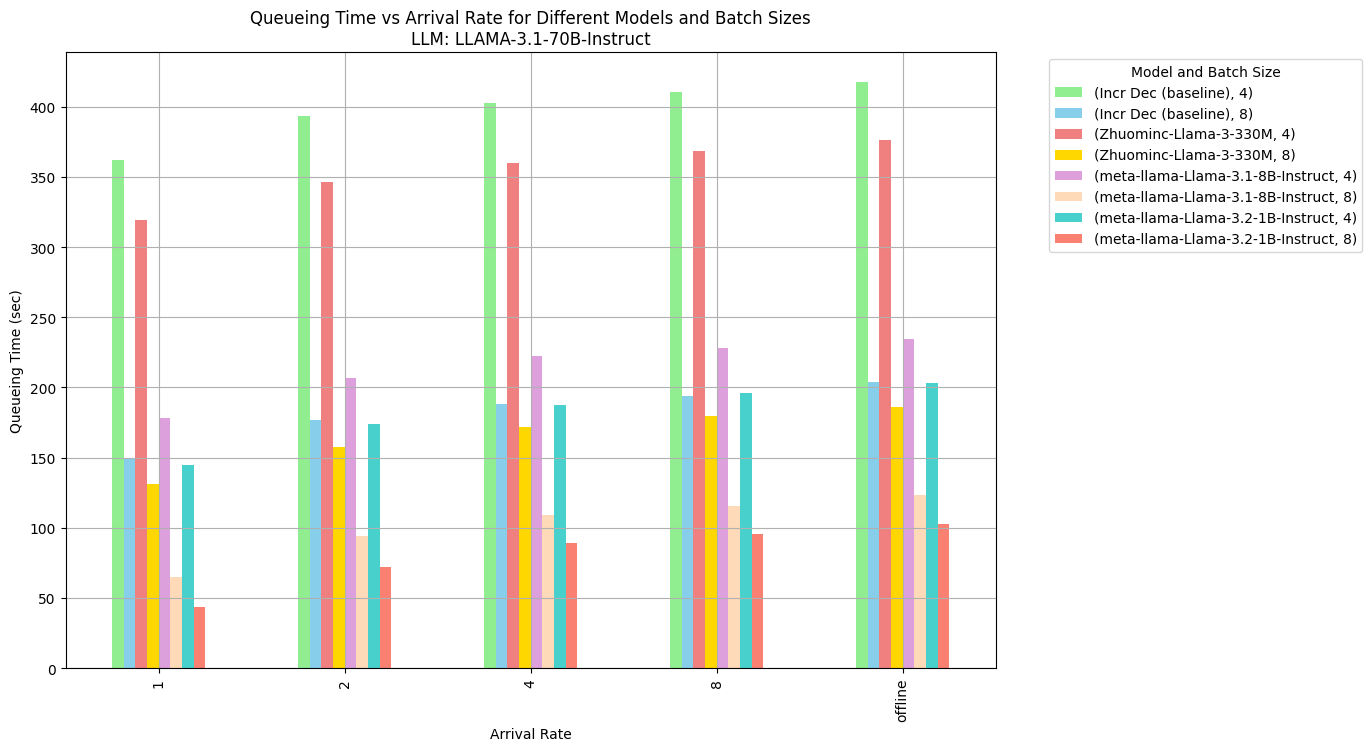

In [7]:
# Create a list to store the queueing time data
qt_data = []

# Iterate over the models, batch sizes, and arrival rates to calculate queueing time
for ssm in small_model_names:
    for batch_size in batch_sizes:
        for arrival_rate in arrival_rates:
            model_name = ssm.replace("/", "-")
            filepath = f"/usr/FlexFlow/inference/output/specinfer_llm_meta-llama-Llama-3.1-70B-Instruct_ssm_{model_name}_bz_{batch_size}_rate_{arrival_rate}_dataset_sharegpt.csv"
            if os.path.exists(filepath):
                qt = get_queueing_time(filepath)
                qt_data.append({
                    'Model': model_name,
                    'Batch Size': batch_size,
                    'Arrival Rate': arrival_rate,
                    'Queueing Time': qt
                })
# add incremental decoding entry
for batch_size in batch_sizes:
    for arrival_rate in arrival_rates:
        model_name = ssm.replace("/", "-")
        filepath = f"/usr/FlexFlow/inference/output/incr_dec_llm_meta-llama-Llama-3.1-70B-Instruct_bz_{batch_size}_rate_{arrival_rate}_dataset_sharegpt.csv"
        if os.path.exists(filepath):
            qt = get_queueing_time(filepath)
            qt_data.append({
                'Model': "Incr Dec (baseline)",
                'Batch Size': batch_size,
                'Arrival Rate': arrival_rate,
                'Queueing Time': qt
            })

# Convert the list to a DataFrame
qt_df = pd.DataFrame(qt_data)
print(qt_df.head())

# Pivot the dataframe to have models and batch sizes as columns
pivot_df = qt_df.pivot_table(index='Arrival Rate', columns=['Model', 'Batch Size'], values='Queueing Time')

# Plot the data
fig, ax = plt.subplots(figsize=(12, 8))

colors = ['lightgreen', 'skyblue', 'lightcoral', 'gold', 'plum', 'peachpuff', 'mediumturquoise', 'salmon']
pivot_df.plot(kind='bar', ax=ax, color=colors)

ax.set_title('Queueing Time vs Arrival Rate for Different Models and Batch Sizes\nLLM: LLAMA-3.1-70B-Instruct')
ax.set_xlabel('Arrival Rate (requests/sec)')
ax.set_ylabel('Queueing Time (sec)')
ax.grid(True)
ax.legend(title='Model and Batch Size', bbox_to_anchor=(1.05, 1), loc='upper left')

# Save the plot as a PDF
plt.savefig('/usr/FlexFlow/benchmarking/queueing_time_vs_arrival_rate.pdf', bbox_inches='tight')

plt.show()